In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

#### Load and Preview Excel Data ####

First, we start off by loading the two sheets for transactions CY 2009 and CY 2010 into Dataframes and observe what the data looks like

In [44]:
file_path = '../sample_data/transaction_data.xlsx'
transaction_data = pd.read_excel(file_path, sheet_name= None)
transaction_data.keys()

dict_keys(['Year 2009-2010', 'Year 2010-2011'])

In [45]:
transactions_2009 = transaction_data['Year 2009-2010']
print(f"Transactions from {transactions_2009['InvoiceDate'].min()} -> {transactions_2009['InvoiceDate'].max()}")
transactions_2009.head()

Transactions from 2009-12-01 07:45:00 -> 2010-12-09 20:01:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [46]:
transactions_2010 = transaction_data['Year 2010-2011']
print(f"Transactions from {transactions_2010['InvoiceDate'].min()} -> {transactions_2010['InvoiceDate'].max()}")
transactions_2010.head()

Transactions from 2010-12-01 08:26:00 -> 2011-12-09 12:50:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Merge Data and Remove Duplicates ####

We observe that 2009-2010 transactions contain records uptill 9th Dec 2010, while 2010-2011 transactions records start from 1st Dec 2010. This indicates that there may be an overlap between the two Dataframes.

To simplify analysis and maintain data integrity, we will first merge the data and then remove duplicates


In [54]:
transactions_df = pd.concat([transactions_2009, transactions_2010])
print(f"Number of rows before removing duplicates: {transactions_df.shape[0]}")

transactions_df = transactions_df.drop_duplicates()
print(f"Number of rows after removing duplicates: {transactions_df.shape[0]}")


Number of rows before removing duplicates: 1067371
Number of rows after removing duplicates: 1033036


#### Monthly Order Metrics ####

Now, since we have a single Dataframe with all our data, we want to take a look at some Monthly Order Metrics.
* Number of Orders per Month (Count of Unique Invoices)
* Number of Active Customers per month (Customers with at least one Invoice in a given month)
* Monthly Revenue

In [91]:
# Create a YearMonth column to aggregate data by Month and Year
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'])
transactions_df['YearMonth'] = transactions_df['InvoiceDate'].dt.strftime('%Y-%m')

# Calculate Order Item level Revenue Data 
transactions_df['LineItemRevenue'] = transactions_df['Quantity'] * transactions_df['Price']

# Aggregate the data to get monthly unique invoices and active customers from 2009-2010
monthly_metrics = transactions_df.groupby('YearMonth').agg(
    active_customers = ('Customer ID', 'nunique'),
    orders_placed = ('Invoice', 'nunique'),
    revenue = ('LineItemRevenue', 'sum')
).reset_index()

monthly_metrics.head()

,YearMonth,active_customers,orders_placed,revenue
0,2009-12,1045,2330,796648.500
1,2010-01,786,1633,622479.502
2,2010-02,807,1969,531265.366
3,2010-03,1111,2367,763247.241
4,2010-04,998,1892,587926.692


#### Revenue Over Time ####

Now, we want to take a look at month-to-month changes in Order Revenue, and how these changes compare across the two Calendar Years

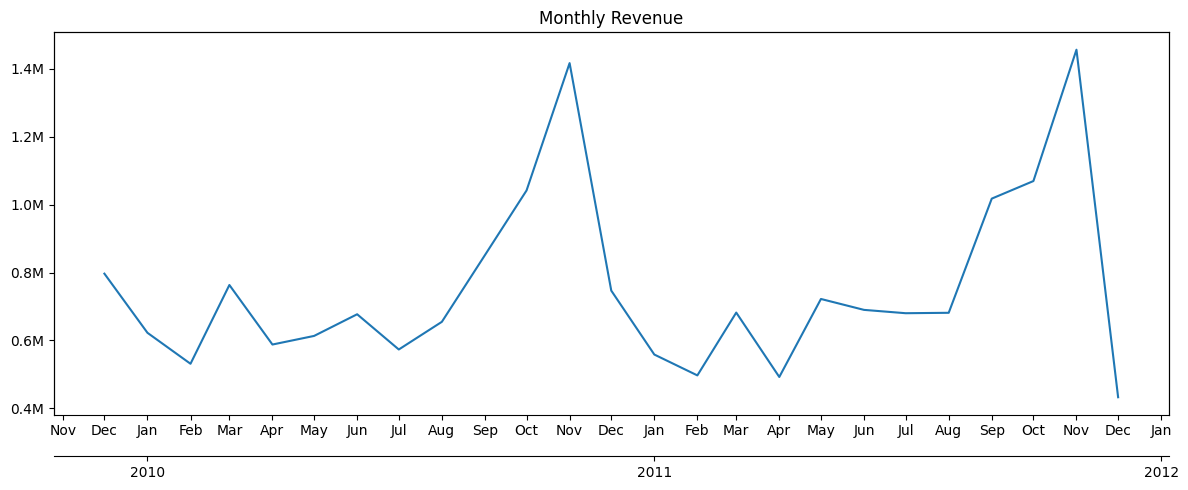

In [87]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(monthly_metrics['YearMonth'], monthly_metrics['revenue'])
ax.set_title('Monthly Revenue')

# Formatting the x-axis  
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Creating a secondary x-axis for the year
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

# Formatting the secondary x-axis
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ensuring the secondary x-axis is positioned below the primary x-axis
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 30))

# Formatting the y-axis units
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

As we can gather from this Line Chart, Revenue seems to stable from year to year, dipping at the start of each year and rising steadily after July.
In addition to this, we see that revenue peaks each year in Early November.

More analysis could help indicate why these seasonal trends exist

#### Top 5 Products ####

Next, we want to observe trends within best-selling products. We can do this by calculating the following metrics on a monthly basis
* Revenue Generated
* Quantity Ordered


In [144]:
# To achieve the right grain for product revenue analysis by month, we aggregate transactions by YearMonth and Product Code, 
# calculating total revenue and total quantity ordered.
product_df = transactions_df.groupby(['YearMonth', 'Description']).agg(
    quantity_ordered = ('Quantity', 'sum'),
    revenue_generated = ('LineItemRevenue', 'sum')
).sort_values(
        by = ['YearMonth', 'revenue_generated', 'quantity_ordered'],  # We can sort by these metrics to get the most popular products
        ascending = [True, False, False]
).reset_index()

product_df.head()

,YearMonth,Description,quantity_ordered,revenue_generated
0,2009-12,DOTCOM POSTAGE,50,18574.58
1,2009-12,WHITE HANGING HEART T-LIGHT HOLDER,6364,17145.45
2,2009-12,PAPER CHAIN KIT 50'S CHRISTMAS,3360,10163.46
3,2009-12,EDWARDIAN PARASOL BLACK,2190,8697.75
4,2009-12,SCOTTIE DOG HOT WATER BOTTLE,1551,7978.96


Now, we want to isolate only the top 5 products for each YearMonth

In [145]:
# Selecting only the top 5 products by revenue and quantity sold for each Year/Month
top_5_products = product_df.groupby('YearMonth').head(5).reset_index()

# Confirming that each Year/Month only contains 5 products
top_5_products['YearMonth'].value_counts().iloc[:5]



YearMonth
2009-12    5
2010-01    5
2010-02    5
2010-03    5
2010-04    5
Name: count, dtype: int64

We can use a heatmap to visualize this information. For Revenue, the heatmap will highlight two kinds of products
* Products that are frequently in the top 5 for revenue generated - These have the most of filled squares (non-white)
* Products that generated the most monthly revenue overall - Squares with the darkest shades of green

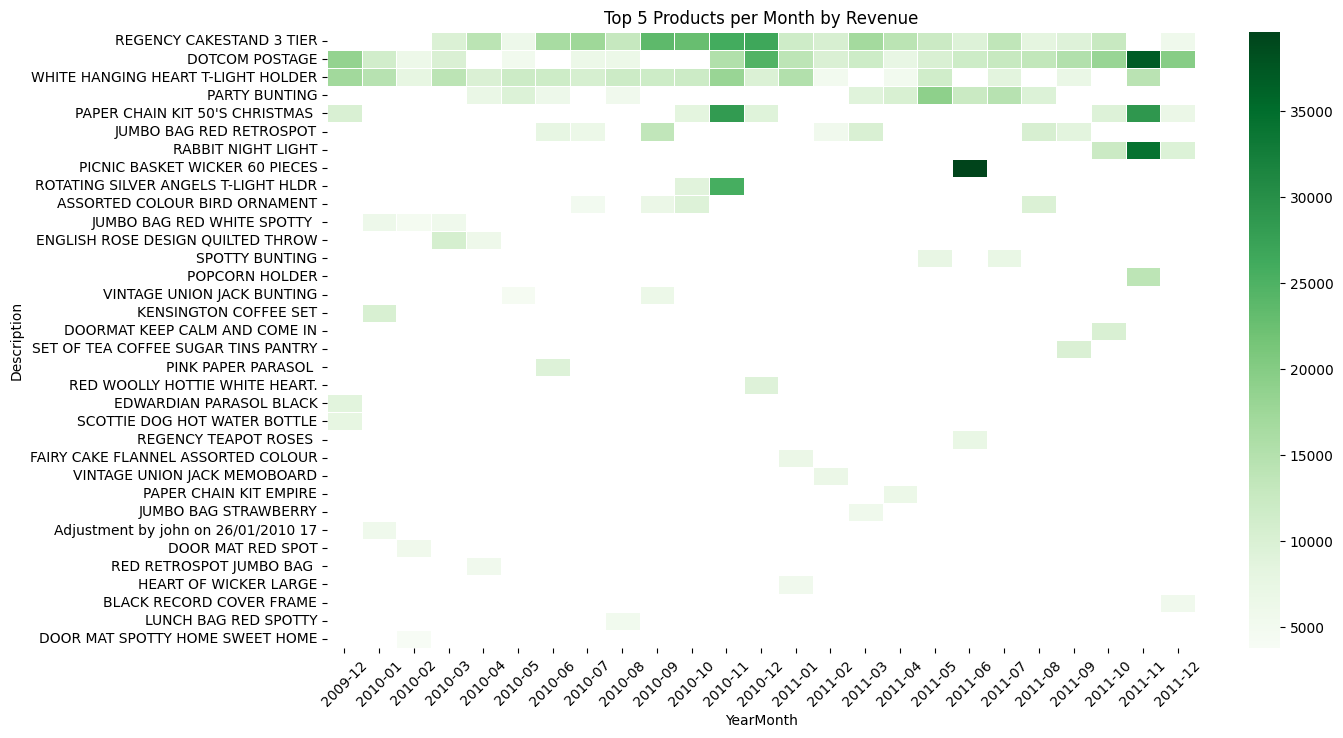

In [ ]:
heatmap_df = top_5_products.pivot(
    index='Description',
    columns='YearMonth',
    values='revenue_generated'
)

# Sorting products by overall revenue (this will pinpoint products that frequently appear in the top 5)
top_products_order = top_5_products.groupby('Description')['revenue_generated'].sum().sort_values(ascending=False).index
heatmap_df = heatmap_df.loc[top_products_order]

# Step 3: Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_df,
    cmap='Greens',      # Yellow → Red gradient
    linewidths=0.5,
)

plt.title("Top 5 Products per Month by Revenue")
plt.xticks(rotation=45)
plt.show()

From this heatmap, we can infer that the following showed up in the Top 5 revenue-generating products most frequently
* Regency Cake Stand 3 Tier
* DOTCOM Postage
* White Hanging Heart T-Light Holder
* Party Bunting
* Paper Chain Kit 50's Christmas

Additionally, we can see that the following products had the greatest monthly revenue highs
* Picnic Basket Wicker (60 pcs) - June 2011
* DOTCOM Postage - Nov 2011
* Rabbit Night Light - Nov 2011
* Paper Chain Kit 50's Christmas - Nov 2010 and Nov 2011

This is in line with the findings from our Line Chart, as the most revenue seems to be generated in November, so it makes sense that overall product-wise revenue peaks would also show up in November